In [8]:
import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import Plotting
import Tools
from joblib import dump, load

In [3]:
def drop_neg(value):
    return value == -999.0

def get_class(value,cls):
    return value != cls

In [4]:
def train():
    df = pd.read_csv("train.csv")

    df = df.filter(regex='DER_mass_MMC|DER_mass_transverse_met_lep|DER_pt_h|DER_deltar_tau_lep|DER_mass_vis|Label|Weight')

    sig = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="s") ].index ).drop('Label',axis=1)
    bkg = df.drop( df[ np.vectorize(get_class,excluded=['cls'])(value=df.Label,cls="b") ].index ).drop('Label',axis=1)

    sig_weights = sig.Weight.values
    bkg_weights = bkg.Weight.values

    sig = sig.drop('Weight',axis=1)
    bkg = bkg.drop('Weight',axis=1)

    clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=4),
                             algorithm="SAMME",
                             n_estimators=200)


    Tools.train_mva(clf,sig,bkg,sig_weights,bkg_weights)

    Plotting.plot_output(clf,sig,bkg)

    dump(clf, "example_sol.joblib")

In [5]:
def test():
    val = pd.read_csv("validation.csv")
    val = val.filter(regex='EventId|DER_mass_MMC|DER_mass_transverse_met_lep|DER_pt_h|DER_deltar_tau_lep|DER_mass_vis')

    clf = load("example_sol.joblib")

    eva = val.drop('EventId',axis=1)

    val['Label'] = clf.predict(eva.values)
    val['DF'] = clf.decision_function(eva.values)

    val = val.sort_values(by='DF',ascending=False).reset_index(drop=True)

    with open('validation_submission.csv','w') as f:
        f.write('EventId,RankOrder,Class\n')
        for index, row in val.iterrows():
            cls = 's' if row.Label == 1.0 else 'b'
            f.write(str(int(row.EventId)))
            f.write(',')
            f.write(str(index+1))
            f.write(',')
            f.write(cls)
            f.write('\n')
        f.close()

<IPython.core.display.Javascript object>


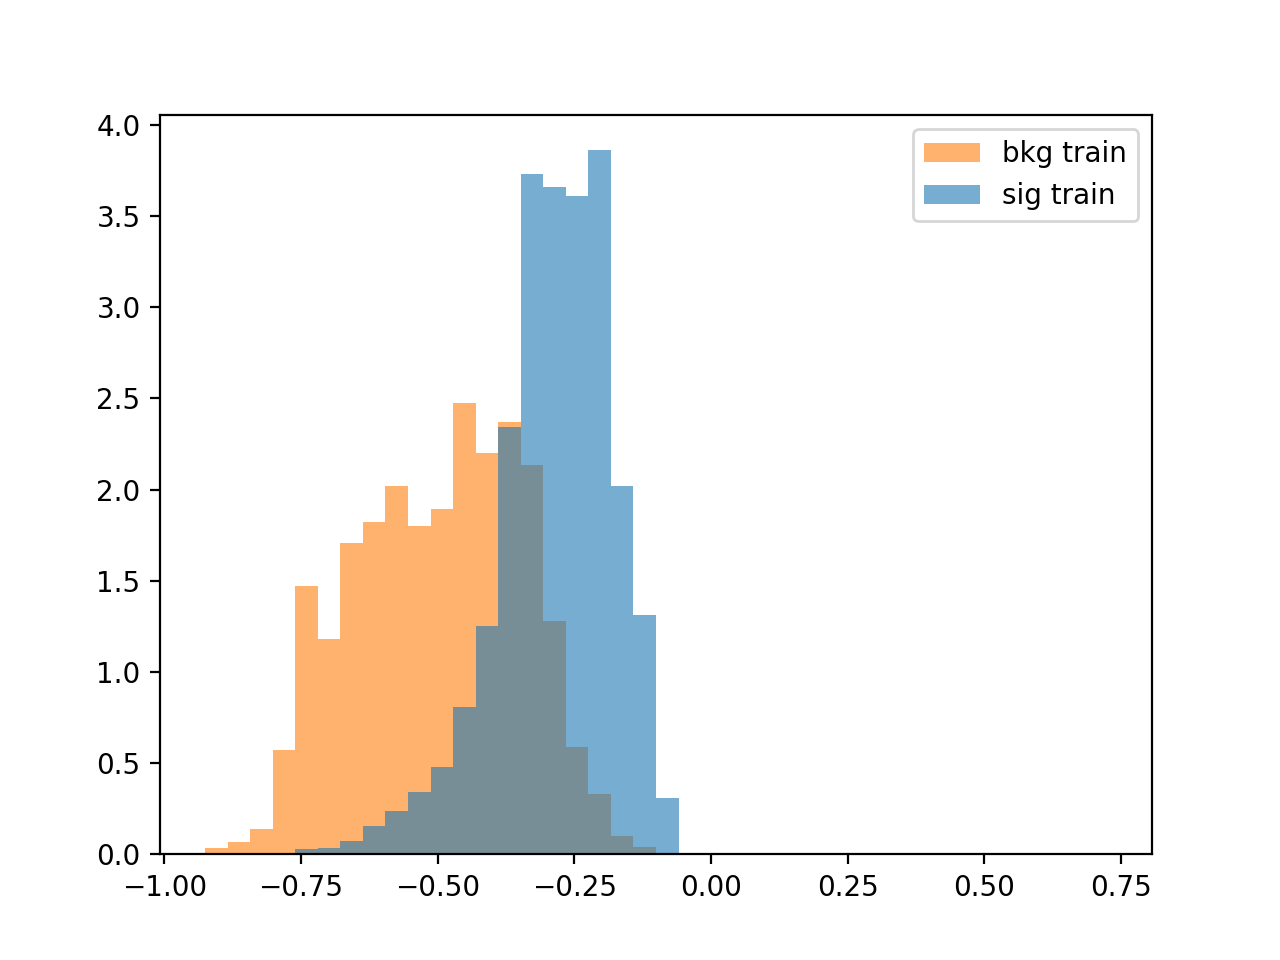

In [10]:
train()

In [7]:
test()